## Import

In [1]:
import numpy as np
import tensorflow as tf

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
from os.path import join

In [3]:
from src.config import MODEL_PATH, CLASS_NAMES

In [4]:
# model preprocess
model_preprocess = {
    "DenseNet": tf.keras.applications.densenet.preprocess_input,
    "EfficientNet": tf.keras.applications.efficientnet.preprocess_input,
    "NasNet": tf.keras.applications.nasnet.preprocess_input,
    "ResNet": tf.keras.applications.resnet_v2.preprocess_input,
}

## The Grad-CAM algorithm

In [5]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [6]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


## Load model

In [7]:
model_name = "EfficientNetB7"
model_family = "EfficientNet"

In [8]:
from src.addons import GCAdam

In [9]:
model = tf.keras.models.load_model(join(MODEL_PATH, f"best_{model_name}.h5"), custom_objects={"GCAdam": GCAdam})

Metal device set to: Apple M1 Pro


2022-02-22 21:12:27.099858: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-22 21:12:27.100009: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
# model.summary()

## See output heatmap

In [11]:
img_path = "/Users/schalappe/Documents/Lab/Engineer/Projects/kenyan_sign_language_classification/data/Images/ImageID_YZ41R7HI.jpg"

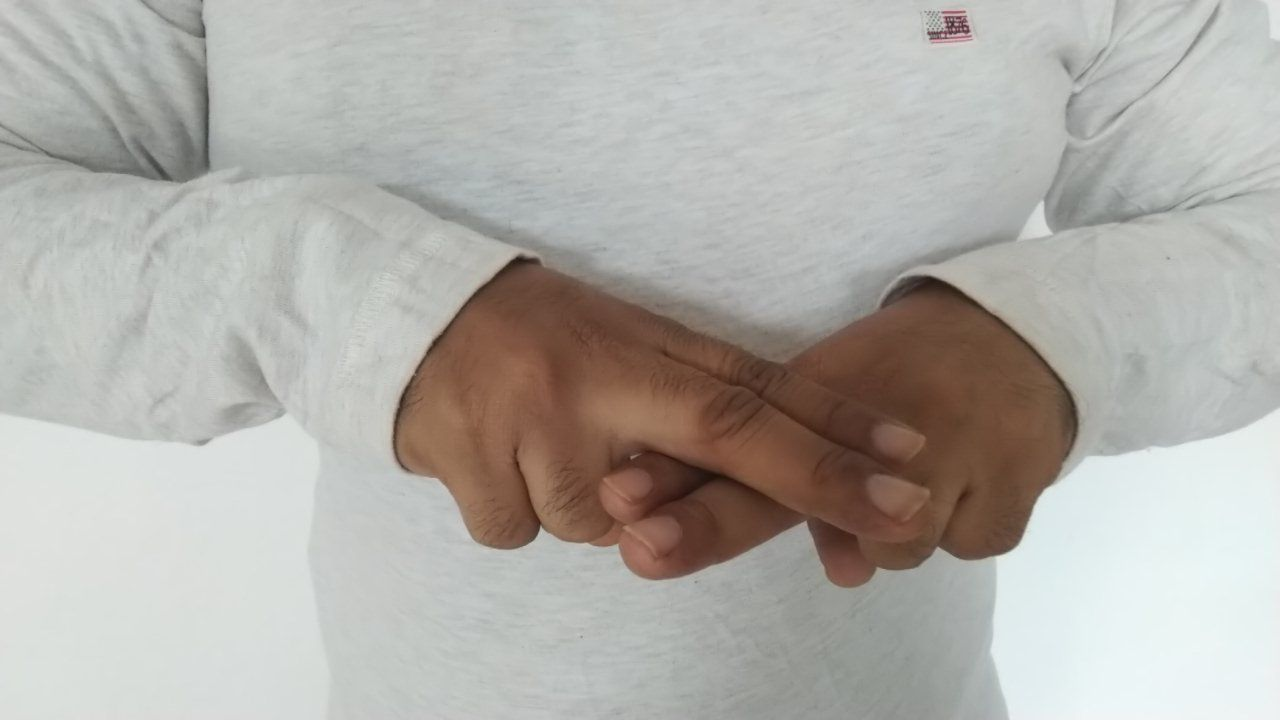

In [12]:
display(Image(img_path))

In [13]:
from src.processors import load_image

In [14]:
image = load_image(img_path, model_preprocess[model_family])
image = tf.image.resize(image, [224, 224])
image = tf.expand_dims(image, axis=0)

In [15]:
tf.shape(image)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  1, 224, 224,   3], dtype=int32)>

In [16]:
# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(image)
print(f"Predicted: {CLASS_NAMES[tf.argmax(preds[0])]}")

2022-02-22 21:12:31.307985: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-22 21:12:32.601803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Predicted: Seat


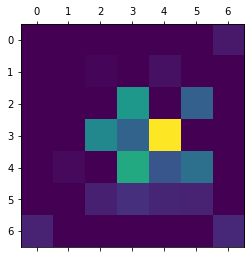

In [18]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(image, model, "top_conv")

# Display heatmap
plt.matshow(heatmap)
plt.show()

## superimposed visualization

In [19]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


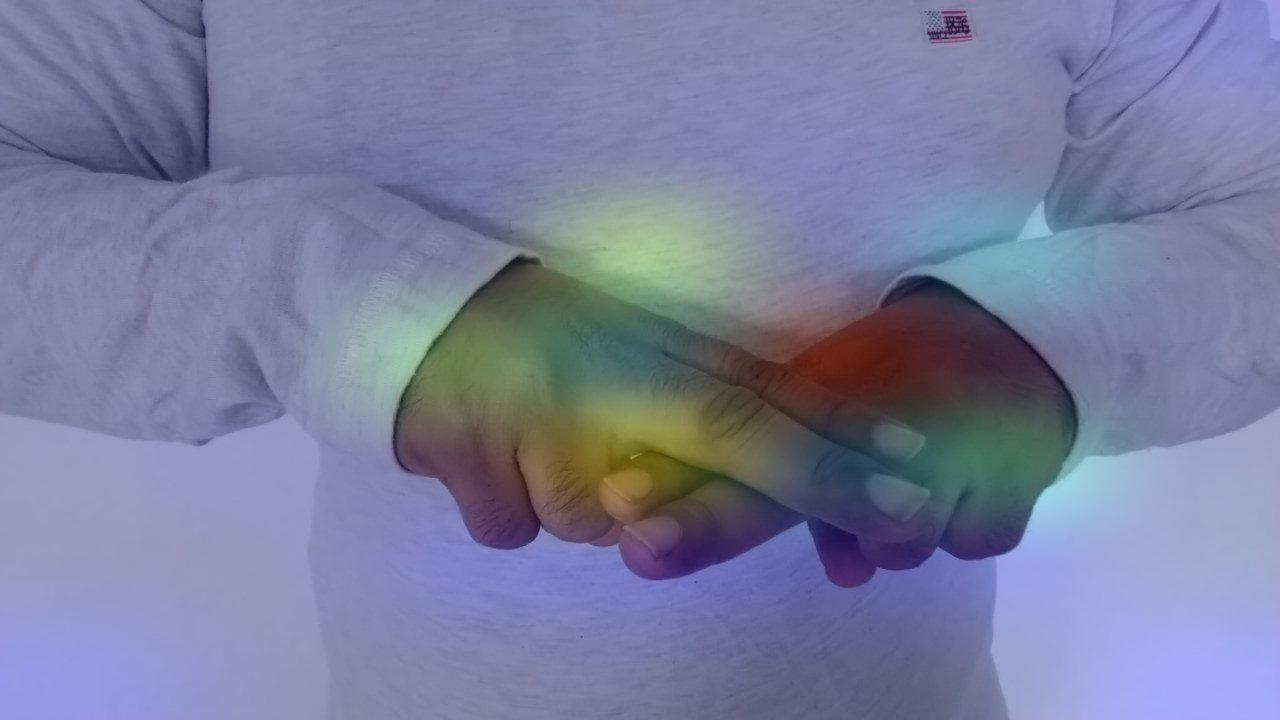

In [20]:
save_and_display_gradcam(img_path, heatmap)